In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from math import *

### Задание функций

Гладкая:

$f(x)=x^2$

In [8]:
f_smooth = lambda x: x*x

Разрывная:

$f(x)=\left\{\begin{matrix}
1,&x > 0\\
-1,&x <= 0 
\end{matrix}\right.$

In [9]:
def f_dis(x):
    return (x > 0).astype(int) - (x <= 0).astype(int)

Осциллирующая:

$f(x)=e^{x}sin{(100x)}$

In [10]:
f_osc = lambda x: np.sin(100*x)*np.exp(x)

### Интерполяция

Граничные условия: x из отрезка [a, b], тогда S''(a) = S''(b) = 0

In [11]:
class Spline():
    def __init__(self, x=None, func=None):
        if ((x is None) and (func is None)):
            return
        if ((x is None) or (func is None)):
            raise ValueError()
        T = np.diff(x)
        N = T.shape[0]
        A = np.zeros((N-1, N-1))
        f = np.zeros(N - 1)
        func_diff = np.diff(func)
        for i in range(N - 1):
            A[i][i] = (T[i] + T[i+1]) / 3
            if (i != 0):
                A[i][i-1] = T[i] / 6
            if (i != N-2):
                A[i][i+1] = T[i+1] / 6
            f[i] = (func[i+2]-func[i+1]) / T[i+1] - (func[i+1]-func[i])/T[i]
        self.m = self.thomas(A, f)
        self.m = np.append(self.m, np.zeros(1))
        self.m = np.append(np.zeros(1), self.m)
        m_diff = np.diff(self.m)
        self.a = func_diff / T - T * m_diff / 6
        self.b = func[:-1]-self.m[:-1]*T*T/6-self.a*x[:-1]
        self.t = x
        
    def thomas(self, A, f):
        N = f.shape[0]
        if (N == 1):
            return f[0] / A[0][0]
        p = np.zeros(N)
        q = np.zeros(N)
        X = np.zeros(N)
        p[1] = -A[0][1]/A[0][0]
        q[1] = f[0] / A[0][0]
        for i in range(1, N-1):
            p[i+1] = -A[i][i+1]/(A[i][i-1]*p[i]+A[i][i])
            q[i+1] = (f[i]-A[i][i-1]*q[i])/(A[i][i-1]*p[i]+A[i][i])
        X[N-1] = (f[N-1]-A[N-1][N-2]*q[N-1])/(A[N-1][N-2]*p[N-1]+A[N-1][N-1])
        for i in range(N-2, -1, -1):
            X[i] = p[i+1]*X[i+1]+q[i+1]
        return X
    
    def __call__(self, x_real):
        f_s = np.zeros(x_real.shape[0])
        for i in range(x_real.shape[0]):
            n = -1
            for j in range(self.t.shape[0] - 1):
                if ((x_real[i] >= self.t[j]) and (x_real[i] <= self.t[j+1])):
                    n = j
                    break
            T = self.t[n + 1] - self.t[n]
            f_s[i] = 1/6/T*(self.m[n]*(self.t[n+1] - x_real[i])**3+self.m[n+1]*(x_real[i] - self.t[n])**3)+self.a[n]*x_real[i]+self.b[n]
        return f_s

Алгоритм:
1. Загружается сетка значений:
    $\begin{vmatrix}
     t_0&  t_1&  ...& t_N\\
     f_0&  f_1& ... & f_N\\
    \end{vmatrix}$
2. По ней строится систему линейных уравнений:
    $A\overrightarrow{m}=\overrightarrow{F}$

    $\begin{pmatrix}
    \frac{\tau_0+\tau_1}{3}  & \frac{\tau_1}{6}  &  0&   ......&  0&\\ 
    \frac{\tau_1}{6} & \frac{\tau_1+\tau_2}{3} & \frac{\tau_2}{6} &   ......& 0 & \\ 
     & . &  . & . &  & \\ 
     &   & . & . & \frac{\tau_{N-2}}{6}&\\ 
     &  &  &  \frac{\tau_{N-2}}{6}&  \frac{\tau_{N-2}+\tau_{N-1}}{3}& \\ 
    \end{pmatrix}
    \begin{pmatrix}
    m_1\\ 
    m_2\\ 
    .\\ 
    .\\ 
    m_{N-1}\\
    \end{pmatrix}
    =
    \begin{pmatrix}
    .\\ 
    .\\ 
    \frac{f_{n+1}-f_n}{\tau_n}-\frac{f_{n}-f_{n-1}}{\tau_{n-1}}\\ 
    .\\ 
    .\\ 
    \end{pmatrix}$

    Где $\tau_n=t_{n+1}-t_{n}$

3. Система решается методом прогонки в функции thomas(A,f):

    Есть матрица трехдиагональная матрица A, вектор переменных x, вектор значений f:

    $\begin{pmatrix}
    b_1  & c_1  &  0&   ......&  0&\\ 
    a_2 & b_2& c_2 &   ......& 0 & \\ 
    0 & . &  . & . &  & \\ 
     &   & . & . & c_{N-1}&\\ 
     0&  ...&  0&  a_N&  b_N& \\ 
    \end{pmatrix}
    \begin{pmatrix}
    x_1\\ 
    x_2\\ 
    .\\ 
    .\\ 
    x_{N}\\
    \end{pmatrix}
    =
    \begin{pmatrix}
    f_1\\ 
    f_2\\ 
    .\\ 
    .\\ 
    f_N\\ 
    \end{pmatrix}$

    Тогда $x_{k-1}$  можно представить в виде: $x_{k-1}=p_kx_k+q_k$

    Можно найти $x_1 = \frac{f_1}{b_1}-\frac{c_1}{b_1}x_2$, отсюда

    $p_2 = -\frac{c_1}{b_1}$; $q_2 = \frac{f_1}{b_1}$

    Также очевидно, что: $a_kx_{k-1}+b_kx_k+c_kx_{k+1}=f_k$

    Теперь коэффиценты $p_{k+1}$, $q_{k+1}$ находятся по формулам:

    $p_{k+1}=-\frac{c_k}{a_kp_k+b_k}$; $q_{k+1}=\frac{f_k-a_kq_k}{a_kp_k+b_k}, k=\overline{2,N-1}$

    $x_N = \frac{f_N-a_Nq_N}{a_Np_N+b_N}$

    Зная $q_{k+1}$, $p_{k+1}$ и $x_{k+1}$ находим $\overrightarrow{x}$
4. Из граничных условий следует $m_0 = m_1 = 0$
    Также вычисляем коэффиценты $A_n$, $B_n$ уравнений сплайнов:
    
    $t\in[t_n, t_{n+1}]$

    $S_n(t)=\frac{1}{6\tau_n}(m_n(t_{n+1}-t_n)^3+m_{n+1}(t-t_n)^3)+A_nt+B_n$
    
    $A_n = \frac{f_{n+1}-f_n}{\tau_n}-\frac{m_{n+1}}{6}\tau_n$
    
    $B_n = f_n-\frac{m_n{\tau_n}^2}{6}-A_nt_n$


In [39]:
def graph(func, left, right, n, title):
    plt.figure(figsize=(8,6))
    h = np.float32(right - left) / n
    t = np.arange(left,right+h/2,h) # сетка
    f = func(t) # сетка
    x_real = np.arange(left,right+h/16, h/8)
    f_real = func(x_real)
    plt.title(title + ', сетка из ' + str(n) + ' элементов')
    plt.plot(x_real, func(x_real), c='b', label='функция')
    plt.scatter(t,f,c='r', s=4, label='узлы')
    s = Spline(t,f)
    plt.plot(x_real, s(x_real), c='orange', label='сплайн')
    plt.legend()

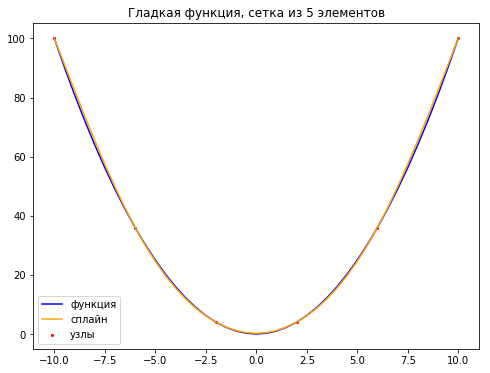

In [40]:
graph(f_smooth, -10, 10, 5, 'Гладкая функция')

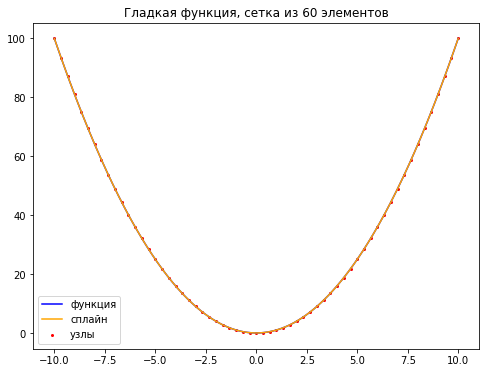

In [41]:
graph(f_smooth, -10, 10, 60, 'Гладкая функция')

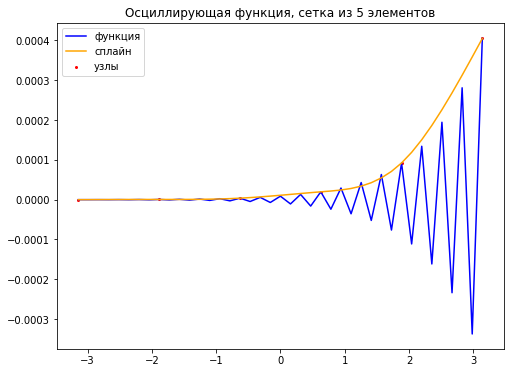

In [42]:
graph(f_osc, -pi, pi, 5, 'Осциллирующая функция')

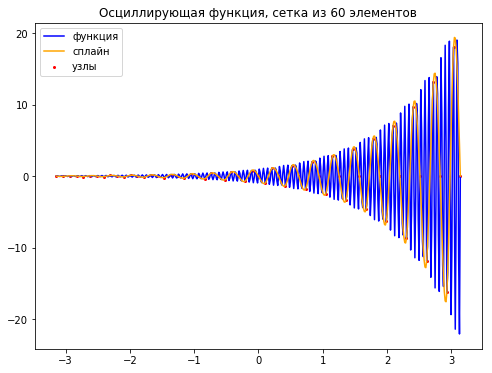

In [43]:
graph(f_osc, -pi, pi, 60, 'Осциллирующая функция')

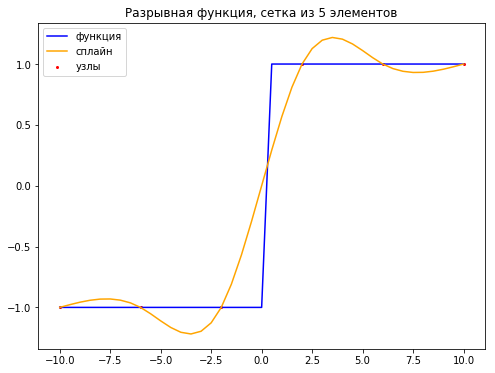

In [44]:
graph(f_dis, -10, 10, 5, 'Разрывная функция')

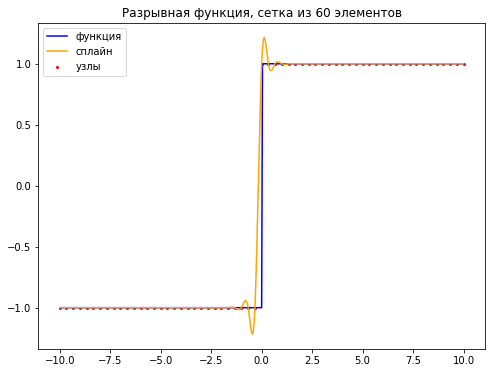

In [45]:
graph(f_dis, -10, 10, 60, 'Разрывная функция')

In [49]:
def error(title, func, left, right, n=60):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    h = np.float32(right - left) / n
    t = np.arange(left,right+h/2,h) # сетка
    f = func(t) # сетка
    x_real = np.arange(left,right+h/16, h/8)
    s = Spline(t, f)
    plt.plot(x_real, func(x_real)-s(x_real), label='$E(x)=f(x)-S(x)$')
    plt.scatter(t,np.zeros(t.shape[0]),c='r', s=3, label='узлы')
    plt.legend()

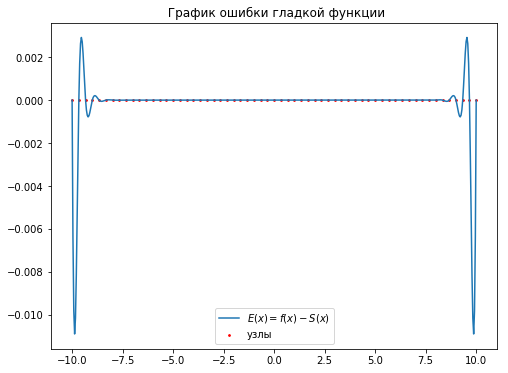

In [53]:
error(' График ошибки гладкой функции', f_smooth, -10, 10)

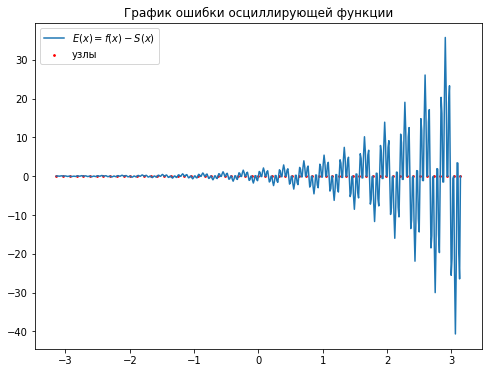

In [54]:
error('График ошибки осциллирующей функции', f_osc, -pi, pi)

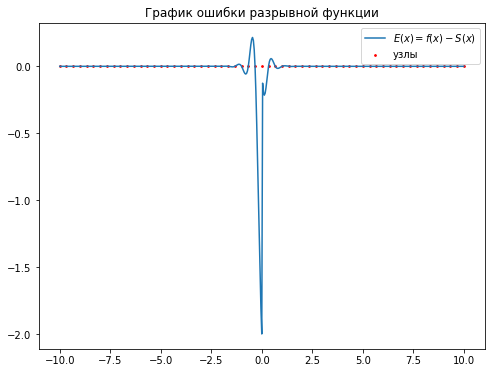

In [55]:
error('График ошибки разрывной функции', f_dis, -10, 10)